In [2]:
import os
os.environ[ "TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity( tf.compat.v1.logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt
import csv

In [3]:
def plot_series( x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
	plt.figure( figsize=( 10, 6))

	if type( y) is tuple:
		for y_curr in y:
			plt.plot( x[ start:end], y_curr[ start:end], format)
	else:
		plt.plot( x[ start:end], y[ start:end], format)

	plt.xlabel( xlabel)
	plt.ylabel( ylabel)
	
	if legend:
		plt.legend( legend)

	plt.title( title)

	plt.grid(True)
	
	plt.show()

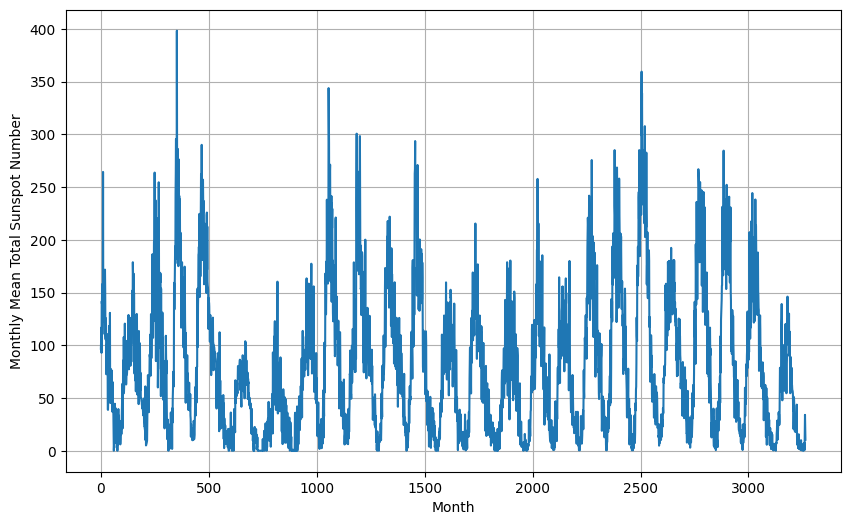

In [4]:
time_step = []
sunspots = []

with open( "./Sunspots.csv") as csvFile:
	reader = csv.reader( csvFile, delimiter=",")

	next( reader) # skip header

	for row in reader:
		time_step.append( int( row[ 0]))
		sunspots.append( float( row[ 2]))

time = np.array( time_step)
series = np.array( sunspots)

plot_series( time, series, xlabel="Month", ylabel="Monthly Mean Total Sunspot Number")

In [5]:
split_time = 3000

time_train = time[ :split_time]
x_train = series[ :split_time]

time_valid = time[ split_time:]
x_valid = series[ split_time:]

In [6]:
def windowed_dataset( series, window_size, batch_size, shuffle_buffer):
	dataset = tf.data.Dataset.from_tensor_slices( series)
	
	dataset = dataset.window( window_size + 1, shift=1, drop_remainder=True)

	dataset = dataset.flat_map( lambda window: window.batch( window_size + 1))

	dataset = dataset.map( lambda window: ( window[ :-1], window[ -1]))

	dataset = dataset.shuffle( shuffle_buffer)

	dataset = dataset.batch( batch_size).prefetch( 1)

	return dataset

In [7]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
train_set = windowed_dataset( x_train, window_size, batch_size, shuffle_buffer_size)

In [9]:
model = tf.keras.models.Sequential( [
	tf.keras.layers.Conv1D(
		filters=64,
		kernel_size=3,
		strides=1,
		padding="causal",
		activation="relu",
		input_shape=[ window_size, 1]
	),
	tf.keras.layers.LSTM( 64, return_sequences=True),
	tf.keras.layers.LSTM( 64),
	tf.keras.layers.Dense( 30, activation="relu"),
	tf.keras.layers.Dense( 10, activation="relu"),
	tf.keras.layers.Dense( 1),
	tf.keras.layers.Lambda( lambda x: x * 400.0)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [10]:
init_weight = model.get_weights()

In [11]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
	lambda epoch: 1e-8 * 10 ** ( epoch / 20)
)

optimizer = tf.keras.optimizers.SGD( momentum=0.9)

model.compile(
	loss=tf.keras.losses.Huber(),
	optimizer=optimizer
)

history = model.fit(
	train_set,
	epochs=100,
	callbacks=[ lr_schedule],
	verbose=0
)

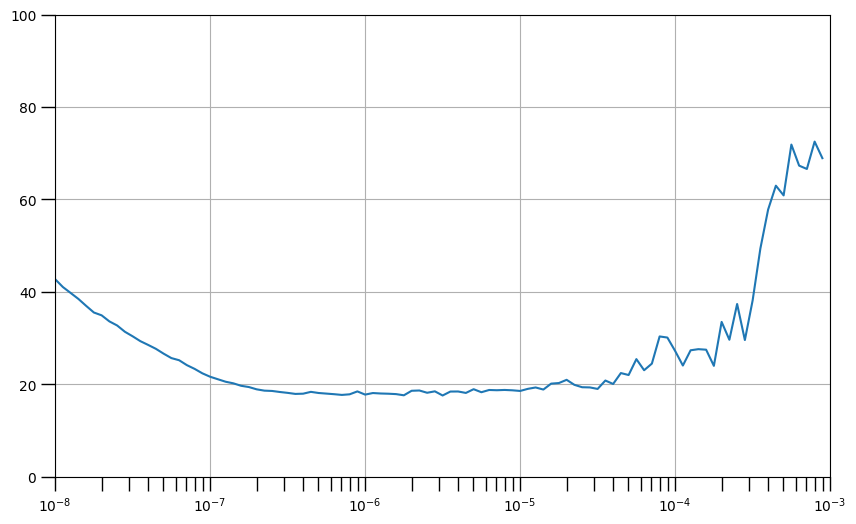

In [12]:
lrs = 1e-8 * ( 10 ** ( np.arange( 100) / 20))

plt.figure( figsize=( 10, 6))

plt.grid( True)

plt.semilogx( lrs, history.history[ "loss"])

plt.tick_params( "both", length=10, width=1, which="both")

plt.axis( [ 1e-8, 1e-3, 0, 100])

plt.show()

In [13]:
tf.keras.backend.clear_session()

model.set_weights( init_weight)

In [14]:
learning_rate = 3e-7

optimizer = tf.keras.optimizers.SGD(
	learning_rate=learning_rate,
	momentum=0.9
)

model.compile(
	loss=tf.keras.losses.Huber(),
	optimizer=optimizer,
	metrics=[ "mae"]
)

In [15]:
history = model.fit(
	train_set,
	epochs=100,
	verbose=0
)

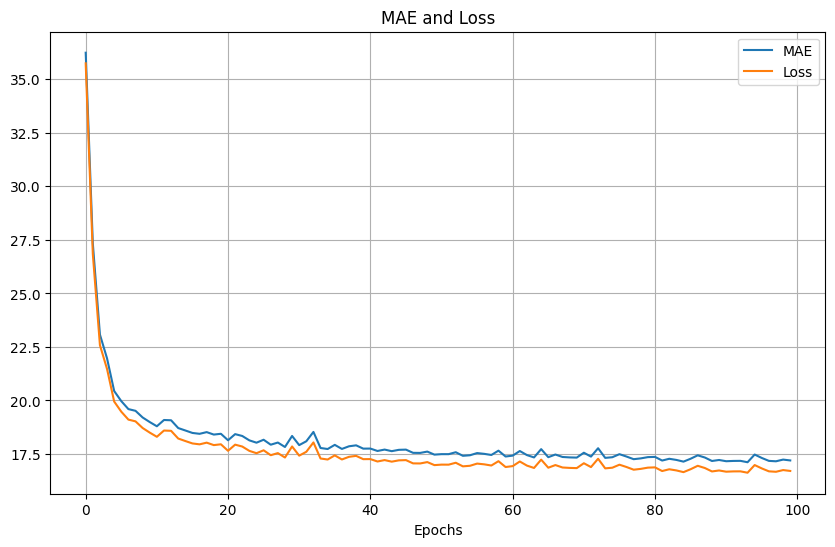

In [16]:
loss = history.history[ "loss"]
mae = history.history[ "mae"]

epochs = range( len( loss))

plot_series(
	x=epochs,
	y=( mae, loss),
	title="MAE and Loss",
	xlabel="Epochs",
	legend=[ "MAE", "Loss"]
)

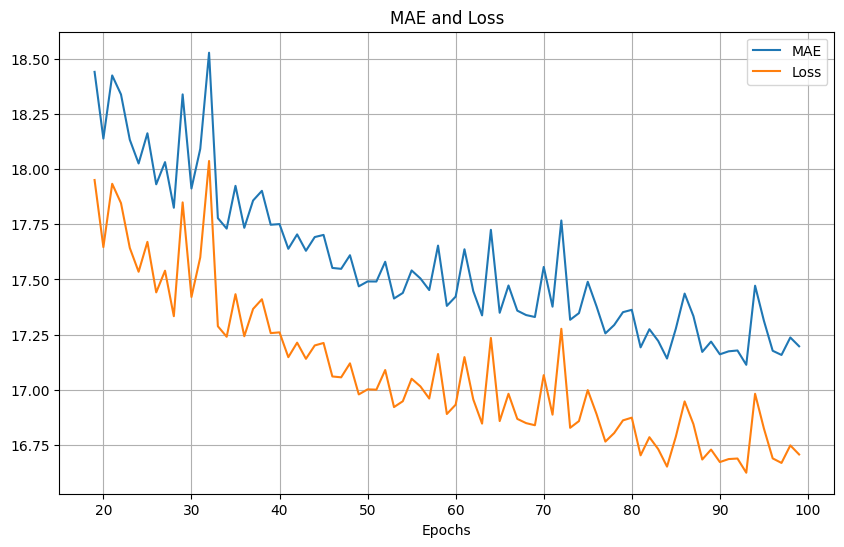

In [17]:
zoom_split = int( epochs[ -1] * 0.2)
epochs_zoom = epochs[ zoom_split:]
mae_zoom = mae[ zoom_split:]
loss_zoom = loss[ zoom_split:]


plot_series(
	x=epochs_zoom,
	y=( mae_zoom, loss_zoom),
	title="MAE and Loss",
	xlabel="Epochs",
	legend=[ "MAE", "Loss"]
)

In [18]:
def model_forecast( model, series, window_size, batch_size):

	dataset = tf.data.Dataset.from_tensor_slices( series)

	dataset = dataset.window( window_size, shift=1, drop_remainder=True)

	dataset = dataset.flat_map( lambda w: w.batch( window_size))

	dataset = dataset.batch( batch_size).prefetch( 1)

	forecast = model.predict( dataset, verbose=0)

	return forecast

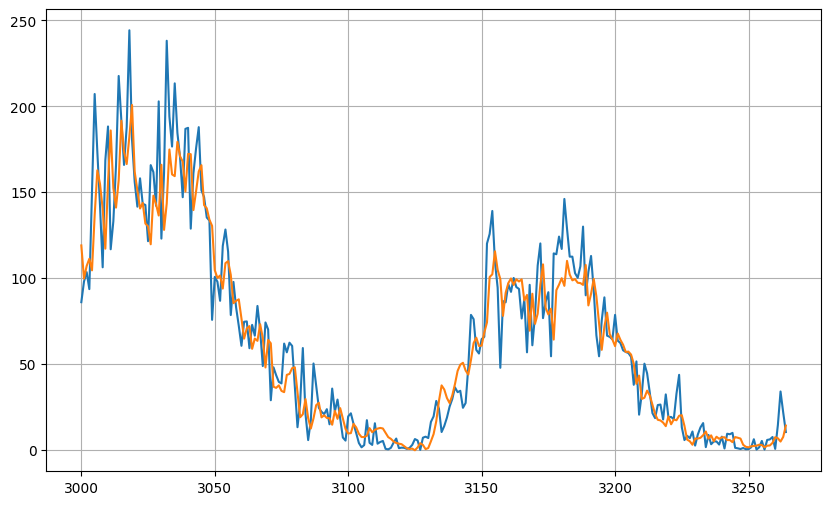

In [19]:
forecast_series = series[ split_time - window_size:-1]

forecast = model_forecast( model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series( time_valid, ( x_valid, results))

In [20]:
print( tf.keras.metrics.mean_squared_error( x_valid, results).numpy())
print( tf.keras.metrics.mean_absolute_error( x_valid, results).numpy())

401.15396
13.543118
